In [1]:
from src.capstone.cbf import CBF, InfeasibilityError
from src.capstone.settings import Env
from src.capstone.noise import LunarLanderNoise
from src.capstone.nndm import NNDM
from src.capstone.ddpg import Actor

import numpy as np
import gymnasium as gym

from bound_propagation.polynomial import Pow
from bound_propagation.linear import FixedLinear

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import os

We make a plot similar to the Quadruped example of the Robust Safety paper (figure 1). In this case, we apply a simple constraint: an x range $[-0.2, 0.2]$ in which the Lander must remain. This corresponds to the positions of the flags that mark the landing area.

$$h(x) = 1 - \frac{x^2}{0.2^2} = 1-25x^2$$

In [2]:
# allows to set a bound (also on other values than x = 0.2)
x_bound = 0.15

In [3]:

class ContinuousLunarLander(Env):

    def __init__(self, noise: list[float]) -> None:
        env = gym.make("LunarLander-v2", continuous=True)
        
        self.is_discrete = False

        self.settings = {
            'noise': {
                'x': noise[0],
                'y': noise[1],
                'theta': noise[2],
                'v_x': noise[3],
                'v_y': noise[4],
                'v_theta': noise[5]
            },

            'replay_size': 1_000_000,
            'batch_size': 128,
            'num_episodes': 3000,
            'max_frames': 1000,  # so that the lander prioritizes landing quick

            'gamma': 0.99,
            'tau': 0.001,

            'NNDM_layers': (64,),
            'NNDM_activation': nn.Tanh,
            'NNDM_criterion': nn.MSELoss,
            'NNDM_optim': optim.Adam,
            'NNDM_lr': 1e-3,

            'Actor_layers': (256, 128, 64),
            'Actor_activation': F.relu,
            'Actor_optim': optim.AdamW,
            'Actor_lr': 1e-4,
            'Action_bound': 1.,  # action space is bounded to [-1, 1] - see gymnasium docs

            'Critic_layers': {'s': (256, 128), 'a': (128,), 'concat': (128,)},
            'Critic_activation': F.relu,
            'Critic_criterion': nn.SmoothL1Loss,
            'Critic_optim': optim.AdamW,
            'Critic_lr': 1e-3,

            'OU_mu': 0,
            'OU_theta': 0.15,
            'OU_sigma': 0.2
        }

        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1., 0, 0, 0, 0, 0]
                ]),
                torch.tensor([0., 0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / x_bound ** 2, 0],
                    [0, -1 / 4. ** 2]
                ]),
                torch.tensor([1., 1.])
            )
        )

        self.h_ids = [0, 2]
        self.std = [noise[i] for i in self.h_ids]
        self.env = LunarLanderNoise(env, self.settings['noise'])

In [4]:
# positions - 0.005, velocities - 0.025
env = ContinuousLunarLander([0.005, 0.005, 0.025, 0.025, 0.005, 0.025])

# Alpha

$$\nabla^2 h = \begin{bmatrix}
-50
\end{bmatrix}$$

$$\nabla^2 h^T \ \nabla^2 h = \begin{bmatrix}
2500
\end{bmatrix}$$

$$det(\nabla^2 h^T \ \nabla^2 h - \sigma I) = 2500 - \sigma = 0$$

$$\sigma = 2500$$

$$\lambda_{max} = \sqrt{\sigma} = 50$$

In [5]:
lambda_max = 50

stds = [0.005, 0.005, 0.025, 0.025, 0.005, 0.025]
tr_cov = sum(std ** 2 for std in stds)

psi = (lambda_max / 2) * tr_cov
alpha = 1 - psi

print(f'Alpha is {round(alpha, 3)}')

Alpha is 0.951


# NNDM

In [6]:
nndm = NNDM(env)
nndm_params = torch.load(f'../models/NNDMs/{type(env).__name__}')
nndm.load_state_dict(nndm_params)

<All keys matched successfully>

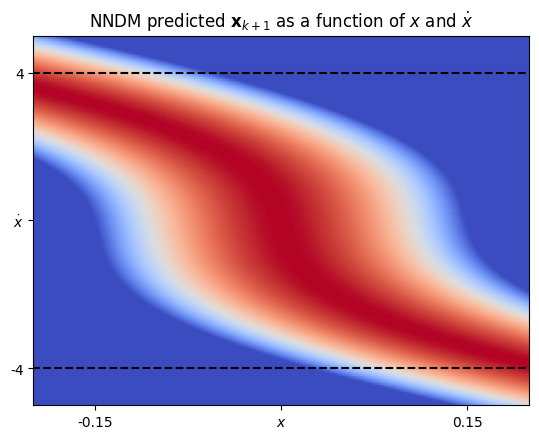

In [7]:
n = 201

x = np.linspace(-x_bound-0.1, x_bound+0.1, n)
xdot = np.linspace(-6, 6, n)

test = torch.zeros((n*n, 10))

for i in range(n):
    test[i*n:(i+1)*n, 0] = torch.tensor(x)
    test[i*n:(i+1)*n, 2] = xdot[i]
    
next_states = nndm(test).detach()
hs = env.h_function(next_states)

xg, yg = np.meshgrid(x, xdot)
clrs = hs[:, 0].numpy().reshape(n, n)

plt.scatter(xg, yg, c=clrs, cmap=plt.colormaps['coolwarm'], vmin=0, vmax=1)
plt.hlines([-4.0, 4.0], -x_bound-0.1, x_bound+0.1, colors='black', linestyles='dashed')

plt.title('NNDM predicted $\mathbf{x}_{k+1}$ as a function of $x$ and $\dot{x}$')
plt.xticks([-0.15, 0., 0.15], ['-0.15', '$x$', '0.15'])
plt.yticks([-4, 0., 4], ['-4', '$\dot{x}$', '4'])

plt.xlim(-0.2, 0.2)
plt.ylim(-5, 5)

plt.show()

# Agent

In [8]:
policy = Actor(env)
policy_params = torch.load(f'../models/Agents/{type(env).__name__}')
policy.load_state_dict(policy_params)

<All keys matched successfully>

# Evaluate

In [9]:
cbf = CBF(env, nndm, policy,
          alpha=[alpha, alpha],
          delta=[0., 0.],
          no_action_partitions=4,
          no_noise_partitions=16,
          stochastic=True)

In [10]:
def mc_simulate(num_agents, cbf_enabled=False, seed=42):
    unsafe_frames = []
    
    if cbf_enabled:
        for f in os.listdir('LunarCBF'):
            os.remove(os.path.join('LunarCBF', f))
        try:
            os.remove('LunarTermination/CBF.npy')
        except FileNotFoundError:
            pass
    else:
        for f in os.listdir('LunarAgent'):
                os.remove(os.path.join('LunarAgent', f))
        try:
            os.remove('LunarTermination/Agent.npy')
        except FileNotFoundError:
            pass
    
    idx = 1
    while idx <= num_agents:
        xy_list = []
        state, _ = env.env.reset(seed=seed)
        xy_list.append(state[:2])
        
        state = torch.tensor(state).unsqueeze(0)

        current_frame = 0
        done = False

        while not done:
            if cbf_enabled:
                try:
                    action = cbf.safe_action(state)
                except InfeasibilityError:
                    print('SCBF infeasibility - change no. partitions')
                    break
            else:
                action = policy.select_action(state, exploration=False)

            state, reward, terminated, truncated, _ = env.env.step(action.squeeze().detach().numpy())
            xy_list.append(state[:2])
            
            state = torch.tensor(state).unsqueeze(0)

            current_frame += 1

            if torch.any(env.h_function(state.unsqueeze(0)) < 0).item():
                unsafe_frames.append(current_frame)
                terminated = True
            
            done = terminated or truncated
            
            if done:
                print(f'{idx}/{num_agents} done', end='\r')
                idx += 1
        
                if cbf_enabled:  
                    np.save(f'LunarCBF/{idx}.npy', np.array(xy_list))
                    np.save('LunarTermination/CBF.npy', np.array(unsafe_frames))
                else:       
                    np.save(f'LunarAgent/{idx}.npy', np.array(xy_list))
                    np.save('LunarTermination/Agent.npy', np.array(unsafe_frames))
    
    env.env.close()

In [32]:
def plot_paths(num_agents=50, generate_data=False):
    if not os.listdir('LunarAgent') or 'Agent.npy' not in os.listdir('LunarTermination') or generate_data:
        mc_simulate(num_agents)
    if not os.listdir('LunarCBF') or 'CBF.npy' not in os.listdir('LunarTermination') or generate_data:
        mc_simulate(num_agents, cbf_enabled=True)
        
    agent_trajectories = [np.load(f'LunarAgent/{fn}') for fn in os.listdir('LunarAgent')]
    cbf_trajectories = [np.load(f'LunarCBF/{fn}') for fn in os.listdir('LunarCBF')]
    
    agent_frames = list(np.load('LunarTermination/Agent.npy'))
    cbf_frames = list(np.load('LunarTermination/CBF.npy'))
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 5))
    
    for agent_run in agent_trajectories:
        ax[0].plot(*zip(*agent_run), color='r', alpha=0.1)
    
    for cbf_run in cbf_trajectories:
        ax[1].plot(*zip(*cbf_run), color='g', alpha=0.1)
    
    ax[0].plot(*zip(agent_trajectories[0][0]), marker='o', color='black', markersize=5)
    ax[1].plot(*zip(cbf_trajectories[0][0]), marker='o', color='black', markersize=5)
        
    ax[0].vlines([-x_bound, x_bound], 0., 1.5, colors='black', linestyles='dashed')
    ax[1].vlines([-x_bound, x_bound], 0., 1.5, colors='black', linestyles='dashed')
    
    ax[0].set_xlim(-0.3, 0.3)
    ax[1].set_xlim(-0.3, 0.3)
    
    ax[0].set_ylim(0., 1.5)
    ax[1].set_ylim(0., 1.5)
    
    ax[0].set_ylabel('y')
    
    ax[0].set_xticks([-0.15, 0., 0.15], ['-0.15', 'x', '0.15'])
    ax[1].set_xticks([-0.15, 0., 0.15], ['-0.15', 'x', '0.15'])
    
    ax[0].set_yticks([0., 0.5, 1.0, 1.5], ['0', '0.5', '1.0', '1.5'])
    ax[1].set_yticks([], [])
    
    fd = {'fontsize': 18,
          'fontweight' : plt.rcParams['axes.titleweight'],
          'verticalalignment': 'baseline',
          'horizontalalignment': 'center'}
    
    ax[0].set_title(f'No filter', fontdict=fd)
    ax[1].set_title(f'Our method', fontdict=fd)
    
    fig.tight_layout()
    
    plt.savefig('plots/LunarLander.png',bbox_inches='tight')
    plt.show()
    
    print(f'No filter - {len(agent_frames)} violations')
    print(f'SCBF - {len(cbf_frames)} violations')

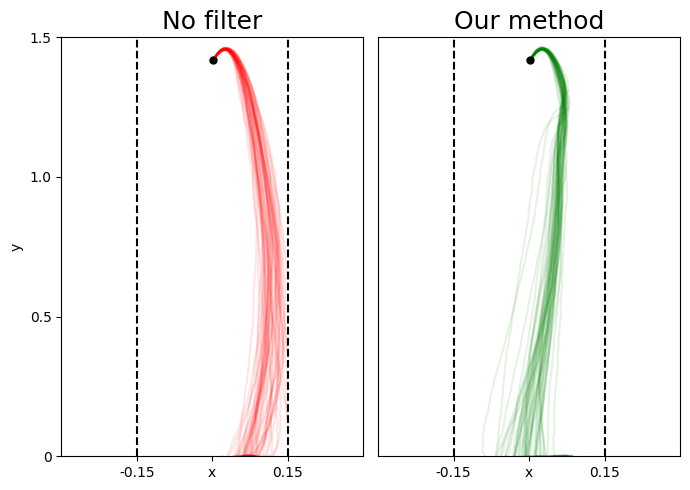

No filter - 6 violations
SCBF - 0 violations


In [33]:
plot_paths(num_agents=50, generate_data=False)

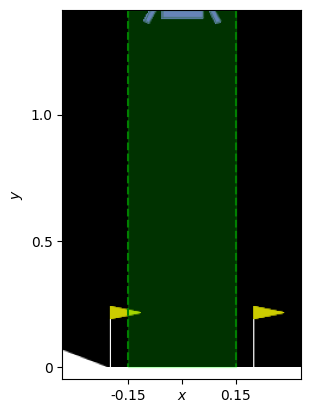

In [45]:
e = gym.make("LunarLander-v2", render_mode='rgb_array')
s, _ = e.reset(seed=42)
y_start = s[1]

start_frame = e.render()

"""Image is 600 x 400 (W x H), floor is at y = 300
Flag poles are 60 px away from x centre - for x_bound = 0.15, this corresponds to 45 px deviation
Aspect ratio should match the plot above W' = (5/8) * 320 = 200"""

plt.imshow(start_frame[:300, (300-100):(300+100), :])

plt.vlines([100-45, 100+45], 0., 300, colors='green', linestyles='dashed')

plt.fill_betweenx(np.linspace(0, 300, 301), 55 * np.ones((301, )), 145 * np.ones((301, )),
                  color='lime', alpha=0.2)

plt.xticks([55, 100, 145], ['-0.15', '$x$', '0.15'])
plt.ylabel('$y$')

plt.yticks([int(300 - (300/y_start)), int(300 - (150/y_start)), 300], ['1.0', '0.5', '0'])

plt.ylim(310, 0)
plt.savefig('plots/LanderEnv.png',bbox_inches='tight')